# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("data/vehicles.csv")
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [3]:
df.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [4]:
df.dtypes

id                int64
region           object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
state            object
dtype: object

The business task is to provide clear recommendations for a used car dealership as to what consumers value in a used car. We know usage value varies based on price, where prices rated higher are vehicles that should be labeled as more likely to be wanted. Thus to frame this as a data question would be as follows:

"Which factors are the most predictive of pricings on used vehicles?"

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Generally, my approach to dataset understanding is working down each column and gathering an understanding of what each said column is all about and what they're representing along with what exactly all the columns together represent for every single row given in the dataset. Thus I'll review one column at a time and gain an insight of the unique values and their spread as well. This slowly builds up my understanding of what a single row may represent in the dataset and how much uniqueness each of these columns contain while also having a fine tuned explantation for why each of them are included. Another important point is simply checking how many missing values are contained per row:

In [5]:
df.isna().sum(), df.shape

(id                   0
 region               0
 price                0
 year              1205
 manufacturer     17646
 model             5277
 condition       174104
 cylinders       177678
 fuel              3013
 odometer          4400
 title_status      8242
 transmission      2556
 VIN             161042
 drive           130567
 size            306361
 type             92858
 paint_color     130203
 state                0
 dtype: int64,
 (426880, 18))

The biggest seems to be the column "size" with 306,361 rows with missing values. We'll need to consider how to handle each row here based on the number of missing values and if we should still include its relevance to price. We'll immediately drop id though since it's just a unique indicator for each row and price since that's our target column.

In [6]:
# Region could be important towards the pricing (some vehicles may be more values based on pricing) 
# so we should keep it here. 
df['region'].value_counts() 

region
columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: count, Length: 404, dtype: int64

In [7]:
# Definitely want to keep these value as well, since price and year may have a numerical correlation. 
# We'll drop the missing values later though to keep the numerical format of the values here.
# We'll also do a transformation with the current year (2025) to better represent this varaibles
# as "car age" instead

df['year'].value_counts()

year
2017.0    36420
2018.0    36369
2015.0    31538
2013.0    30794
2016.0    30434
          ...  
1943.0        1
1915.0        1
1902.0        1
1905.0        1
1909.0        1
Name: count, Length: 114, dtype: int64

In [8]:
# definitely keep, brands may be favored leading to price. Missing values can be exchange for unknown


df['manufacturer'].value_counts() 

manufacturer
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln             4220
volvo               3374
mitsubishi          3292
mini                2376
pontiac             2288
rover               2113
jaguar              1946
porsche             1384
mercury             1184
saturn              1090
alfa-romeo           897
tesla                868
fiat                 792
harley-davidson      153
ferrari               95
datsun                63
aston-martin

In [9]:
# This one is a bit less relavant since we already have brand which tends to already 
# promote specific brands anyway, we'll drop this column in favor of manufacturer.

df['model'].value_counts()

model
f-150                      8009
silverado 1500             5140
1500                       4211
camry                      3135
silverado                  3023
                           ... 
plymouth fury 1               1
f550 box truck delivery       1
duramax 2500hd                1
3 s sport                     1
Paige Glenbrook Touring       1
Name: count, Length: 29649, dtype: int64

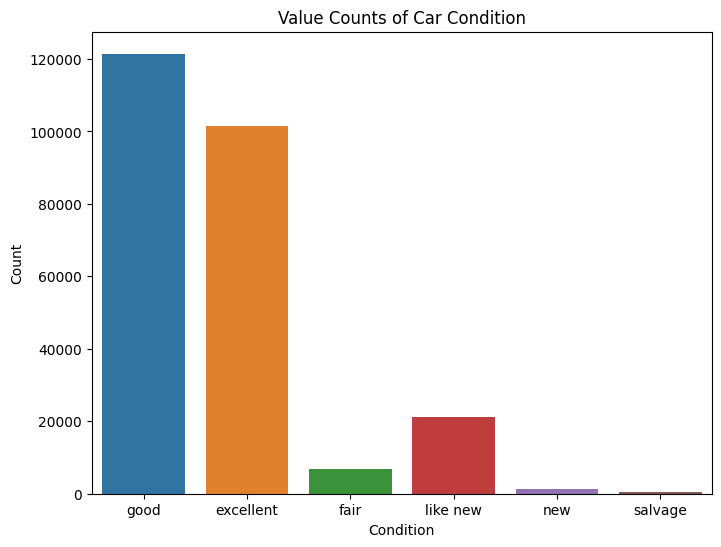

In [10]:
# Should keep this one, better condition may lead to better pricing. Missing values shoudl be replaced with 
# "unknown"

plt.figure(figsize=(8, 6))
sns.countplot(x='condition', data=df)
plt.title('Value Counts of Car Condition')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()

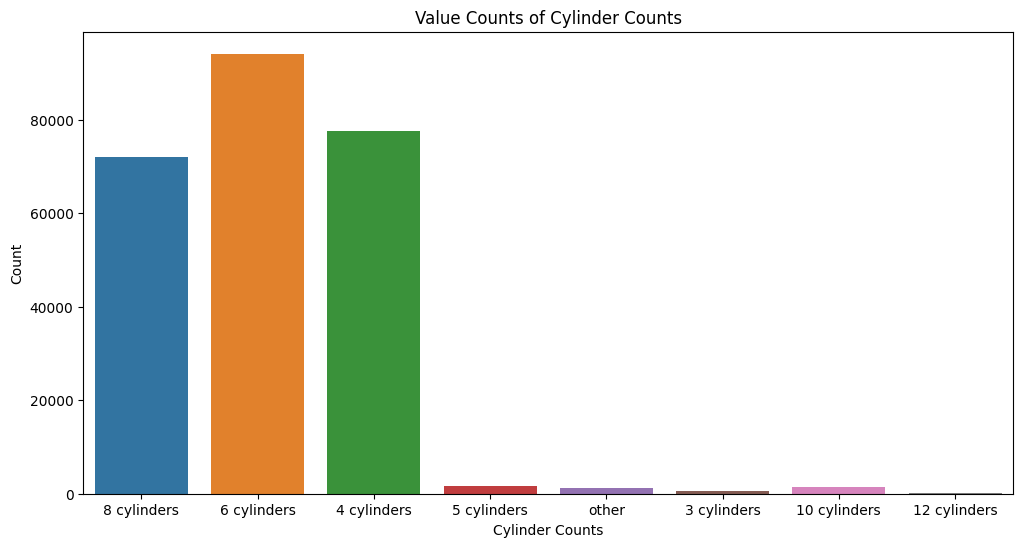

In [11]:
# Cylinders represent vehicle engine power. Uncertain of the full usefulness here especially considering
# the vehicles are used but it still may be a factor to consider. missing values should be replaced with "unknown"

df['cylinders'].value_counts()

plt.figure(figsize=(12, 6))
sns.countplot(x='cylinders', data=df)
plt.title('Value Counts of Cylinder Counts')
plt.xlabel('Cylinder Counts')
plt.ylabel('Count')
plt.show()

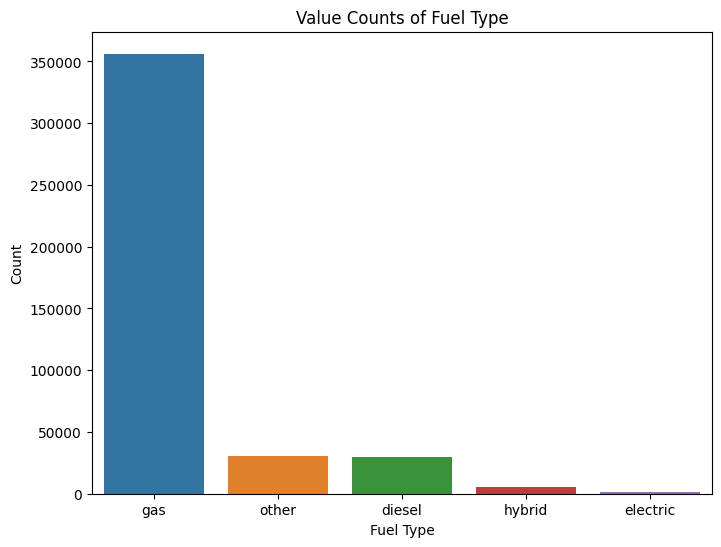

In [12]:
# Definitely keep, certain fuel types may be valued more. Replace missing values with "unknown"
df['fuel'].value_counts()

plt.figure(figsize=(8, 6))
sns.countplot(x='fuel', data=df)
plt.title('Value Counts of Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.show()

In [13]:
# Keep since distance travel could correlate or be relevant to price. We'll remove the missign values to keep 
# the numerical truth.

df['odometer'].value_counts()

odometer
100000.0    2263
1.0         2246
0.0         1965
200000.0    1728
150000.0    1603
            ... 
149468.0       1
154259.0       1
111887.0       1
213826.0       1
26892.0        1
Name: count, Length: 104870, dtype: int64

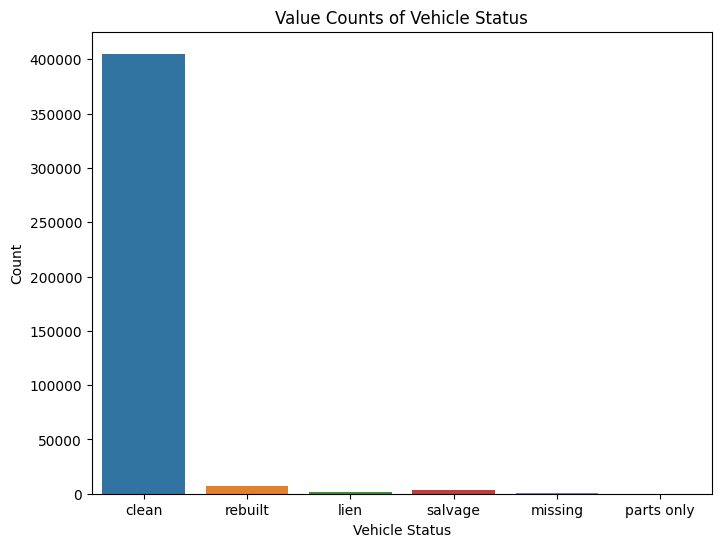

In [14]:
# this column could prove useful since better status means higher pricing. We'll replace the missing values with 
# unknown

df['title_status'].value_counts()

plt.figure(figsize=(8, 6))
sns.countplot(x='title_status', data=df)
plt.title('Value Counts of Vehicle Status')
plt.xlabel('Vehicle Status')
plt.ylabel('Count')
plt.show()

In [15]:
# I don't believe this column will be that useful. Transmission doesn't seem to be a highly valued topic or reason 
# for vehicle preference, so I'll drop it for this study.

df['transmission'].value_counts()

transmission
automatic    336524
other         62682
manual        25118
Name: count, dtype: int64

In [16]:
# Also not very useful. This just acts as a vehicle's id identifier, so I'll drop it here for now.

df['VIN'].value_counts()

VIN
1FMJU1JT1HEA52352    261
3C6JR6DT3KG560649    235
1FTER1EH1LLA36301    231
5TFTX4CN3EX042751    227
1GCHTCE37G1186784    214
                    ... 
1GCEK19J78Z219711      1
JA4AT3AW1AZ006543      1
4T1BF28B61U153724      1
JTHCF5C25A5041393      1
SAJGX2749VCOO8376      1
Name: count, Length: 118246, dtype: int64

In [17]:
# I don't believe this column will be useful either. General market I expect would not be interested how the 
# vehicle works, just that it does so I don't consider the wheel drive type to be impactful here.

df['drive'].value_counts()

drive
4wd    131904
fwd    105517
rwd     58892
Name: count, dtype: int64

In [18]:
# Vehicle size is definitely a factor. Certain car shapes may be preferred. However the missing value count here
# is 3 times as large as the sum of value counts below. As such, I don't believe we should rely on this factor
# with this dataset due to the disparency of missing values ruining the predictions

df['size'].value_counts()

size
full-size      63465
mid-size       34476
compact        19384
sub-compact     3194
Name: count, dtype: int64

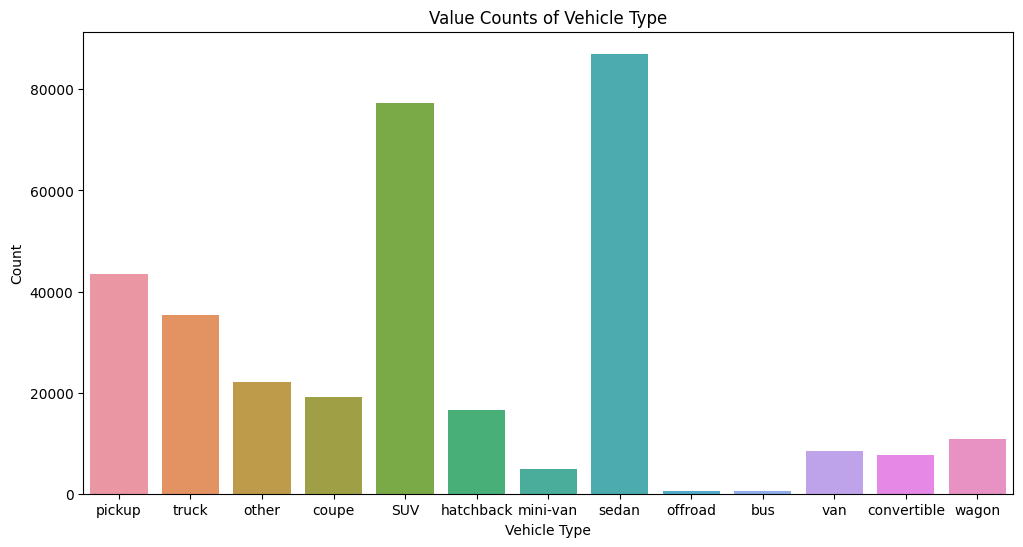

In [19]:
# I think this also falls into "manufacturer" overlap, though not as much as model. That said I also think due
# to certain vehicle being more clear, this is a better variable to use over size and thus should be kept.
# Missing values should be replaced with "unknown".

df['type'].value_counts()

plt.figure(figsize=(12, 6))
sns.countplot(x='type', data=df)
plt.title('Value Counts of Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.show()

In [20]:
# I believe color has little relevance towards pricing here, so this will be dropped

df['paint_color'].value_counts()

paint_color
white     79285
black     62861
silver    42970
blue      31223
red       30473
grey      24416
green      7343
custom     6700
brown      6593
yellow     2142
orange     1984
purple      687
Name: count, dtype: int64

In [21]:
# I believe this is another largely low priority column. State origin shouldn't affect the vehicle pricing at all
# if any.

df['state'].value_counts()

state
ca    50614
fl    28511
tx    22945
ny    19386
oh    17696
or    17104
mi    16900
nc    15277
wa    13861
pa    13753
wi    11398
co    11088
tn    11066
va    10732
il    10387
nj     9742
id     8961
az     8679
ia     8632
ma     8174
mn     7716
ga     7003
ok     6792
sc     6327
mt     6294
ks     6209
in     5704
ct     5188
al     4955
md     4778
nm     4425
mo     4293
ky     4149
ar     4038
ak     3474
la     3196
nv     3194
nh     2981
dc     2970
me     2966
hi     2964
vt     2513
ri     2320
sd     1302
ut     1150
wv     1052
ne     1036
ms     1016
de      949
wy      610
nd      410
Name: count, dtype: int64

We'll apply all the data cleansing here:

In [22]:
df['manufacturer'] = df['manufacturer'].fillna("unknown")
df['condition'] = df['condition'].fillna("unknown")
df['cylinders'] = df['cylinders'].fillna("unknown")
df['fuel'] = df['fuel'].fillna('unknown')
df['title_status'] = df['title_status'].fillna('unknown')
df['type'] = df['type'].fillna('unknown')
no_df = df.drop(["model", "transmission", "VIN", "drive", "size", "paint_color", "state"], axis=1)


sliced_df = no_df[no_df['year'].isna() == False]
sliced_df = sliced_df[sliced_df['odometer'].isna() == False].reset_index(drop=True)
sliced_df['car_age'] = 2025 - sliced_df['year']
sliced_df = sliced_df.drop(["year"], axis=1)
print(sliced_df.shape)
sliced_df.head()

(421344, 11)


,id,region,price,manufacturer,condition,cylinders,fuel,odometer,title_status,type,car_age
0,7316814884,auburn,33590,gmc,good,8 cylinders,gas,57923.0,clean,pickup,11.0
1,7316814758,auburn,22590,chevrolet,good,8 cylinders,gas,71229.0,clean,pickup,15.0
2,7316814989,auburn,39590,chevrolet,good,8 cylinders,gas,19160.0,clean,pickup,5.0
3,7316743432,auburn,30990,toyota,good,8 cylinders,gas,41124.0,clean,pickup,8.0
4,7316356412,auburn,15000,ford,excellent,6 cylinders,gas,128000.0,clean,truck,12.0


Now we have two numerical features of interest, let's see how they compare to the target variable price. Note also we look into logging the target variable price to see if we can do a better job at predicting it due to its very large ranges. First let's do car age:

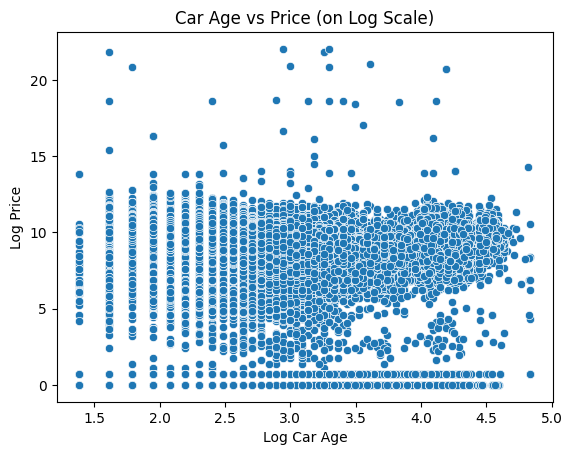

In [23]:
sliced_df['log_car_age'] = np.log1p(sliced_df['car_age'])
sliced_df['log_price'] = np.log1p(sliced_df['price'])

sns.scatterplot(x='log_car_age', y='log_price', data=sliced_df)
plt.xlabel('Log Car Age')
plt.ylabel('Log Price')
plt.title('Car Age vs Price (on Log Scale)')
plt.show()

Seems promosing, let's remove the higher values temporarily and see if there's a deliberate pattern to work with:

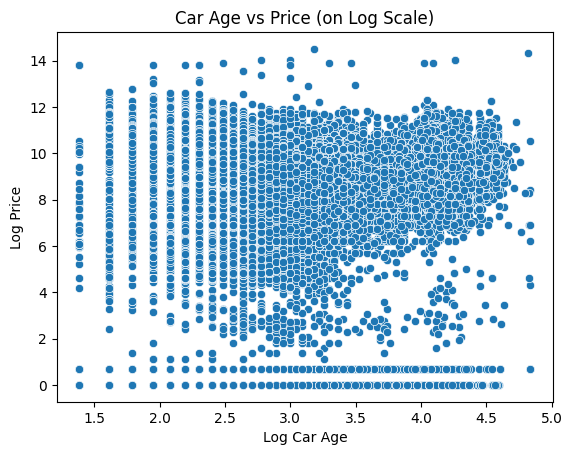

In [24]:
test = sliced_df[sliced_df['price'] <= 2000000]

sns.scatterplot(x='log_car_age', y='log_price', data=test)
plt.xlabel('Log Car Age')
plt.ylabel('Log Price')
plt.title('Car Age vs Price (on Log Scale)')
plt.show()

Looks like car age is a good fit to price. We'll keep the transformations on both it and price moving forward

Next we check out odometer:

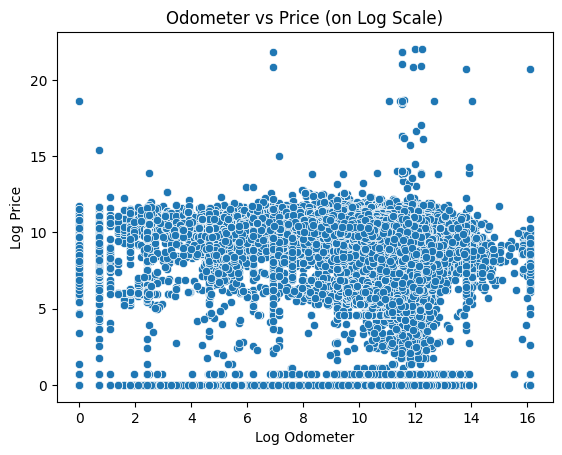

In [25]:
sliced_df['log_odometer'] = np.log1p(sliced_df['odometer'])


sns.scatterplot(x='log_odometer', y='log_price', data=sliced_df)
plt.xlabel('Log Odometer')
plt.ylabel('Log Price')
plt.title('Odometer vs Price (on Log Scale)')
plt.show()

Interesting, let's look a bit further in with the test portion:

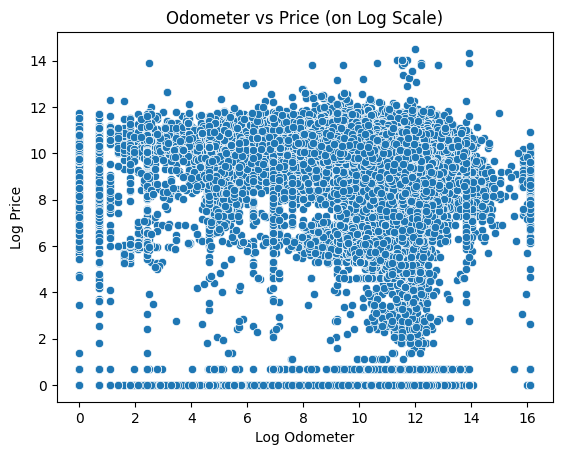

In [26]:
test = sliced_df[sliced_df['price'] <= 2000000]

sns.scatterplot(x='log_odometer', y='log_price', data=test)
plt.xlabel('Log Odometer')
plt.ylabel('Log Price')
plt.title('Odometer vs Price (on Log Scale)')
plt.show()

It seems odometer versus price also creates a decent fit. It seems log transformations are workable on both numerical columns here.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

First we'll do the cleaning and transformations we did in the previous step, plus the log steps we made on 'car age', 'price' and 'odometer':

In [27]:
df['manufacturer'] = df['manufacturer'].fillna("unknown")
df['condition'] = df['condition'].fillna("unknown")
df['cylinders'] = df['cylinders'].fillna("unknown")
df['fuel'] = df['fuel'].fillna('unknown')
df['title-status'] = df['title_status'].fillna('unknown')
df['type'] = df['type'].fillna('unknown')
no_df = df.drop(["id", "model", "transmission", "VIN", "drive", "size", "paint_color", "state", "title_status"], axis=1)


sliced_df = no_df[no_df['year'].isna() == False]
sliced_df = sliced_df[sliced_df['odometer'].isna() == False].reset_index(drop=True)
sliced_df['car-age'] = np.log1p(2025 - sliced_df['year'])
sliced_df['odometer'] = np.log1p(sliced_df['odometer'])
sliced_df['price'] = np.log1p(sliced_df['price'])
sliced_df = sliced_df.drop(["year"], axis=1)
print(sliced_df.shape)
sliced_df.head()

(421344, 10)


,region,price,manufacturer,condition,cylinders,fuel,odometer,type,title-status,car-age
0,auburn,10.422013,gmc,good,8 cylinders,gas,10.966887,pickup,clean,2.484907
1,auburn,10.025307,chevrolet,good,8 cylinders,gas,11.173669,pickup,clean,2.772589
2,auburn,10.586357,chevrolet,good,8 cylinders,gas,9.860632,pickup,clean,1.791759
3,auburn,10.341452,toyota,good,8 cylinders,gas,10.624371,pickup,clean,2.197225
4,auburn,9.615872,ford,excellent,6 cylinders,gas,11.759793,truck,clean,2.564949


Let's split up the features based on data type:

In [28]:
sliced_df.dtypes

region           object
price           float64
manufacturer     object
condition        object
cylinders        object
fuel             object
odometer        float64
type             object
title-status     object
car-age         float64
dtype: object

In [29]:
numeric_features = ['odometer', 'car-age']
categorical_features = ['region', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title-status', 'type']

We can run polynomial features on our numerical features to create a stronge feature varaible. We'll also scale them with standardscaler as well:

In [30]:
numeric_transformer = Pipeline([('polyfeatures', PolynomialFeatures(degree = 3, include_bias = False)),
                      ('scaler', StandardScaler())
                               ])

We'll run one hot encoder on the rest of the columns:

In [31]:
categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

We can then combine both transformers into a single transformer before plugging it into our final pipeline:

In [32]:
full_transformer = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

model_selector_pipe = Pipeline([
    ('transformer', full_transformer),
    ('selector', SelectFromModel(Lasso(alpha = 0.001, random_state = 42, tol = 0.01))),
    ('linreg', LinearRegression())
])

We'll use Lasso along with SelectFromModel as a model to remove the weaker coefficients in our training.

Now we do some train test splits. We'll split of 20% of the original dataset here for testing. Note we'll split again later during cross validation

In [33]:
X, y = sliced_df.drop(["price"], axis=1), sliced_df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

We'll also set up the K folds tester as well. We'll use k = 5 here:

In [34]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

Now we're ready to mess around model creation and testing!

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

Now we can run cross validation to get an idea of the score that our model will achieve. You can see our full work down below where we grab the mean absolute error on each fold along with the important features before finally getting the mean across all folds' errors. (Note we use mean absolute error due to the large range and outlier inside of our target column "price". This is a pre-caution along with the log transformations.) Let's see our results below:

In [35]:
fold_scores = []
coeffs_per_fold = []

def index(x):
        return int(x[1:])

for fold, (train_idx, val_idx) in enumerate(tqdm(kf.split(X_train), total=kf.get_n_splits(), desc="Cross-validation")):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx] # Grab data of train and val split
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model_selector_pipe = Pipeline([
        ('transformer', full_transformer),
        ('selector', SelectFromModel(Lasso(alpha = 0.001, random_state = 42, tol = 0.01))),
        ('linreg', LinearRegression())
    ])
    
    model_selector_pipe.fit(X_tr, y_tr) # train model
    preds = model_selector_pipe.predict(X_val) # model predictions
    
    preds_original = np.expm1(preds) #reconvert log prices to proper amount
    y_val_original = np.expm1(y_val)
    
    score = mean_absolute_error(y_val_original, preds_original) # get mae of fold and record it
    fold_scores.append(score)
    
    tqdm.write(f"Fold {fold + 1} MAE: {score:.2f}")
    
    
    # grab features names and their numerical strength. Since we filtered using lasso these are the features 
    # the model determined most useful
    feature_names = model_selector_pipe.named_steps["transformer"].get_feature_names_out()
    features = model_selector_pipe.named_steps["selector"].get_feature_names_out()
    feature_names = feature_names[list(map(index, features))]
    
    coefs = model_selector_pipe.named_steps["linreg"].coef_
    #print(len(feature_names))
    #print(len(coefs))
    
    coeffs_df = pd.DataFrame({
        "features": feature_names,
        "coefficient": coefs
    })
    
    coeffs_df["fold"] = fold + 1
    
    coeffs_per_fold.append(coeffs_df)
    

print(fold_scores)
print("Mean MAE:", np.mean(fold_scores))

coeffs_all = pd.concat(coeffs_per_fold, ignore_index=True)
coeffs_all

Cross-validation:  20%|█████▍                     | 1/5 [01:33<06:12, 93.10s/it]

Fold 1 MAE: 78861.50


Cross-validation:  40%|██████████▊                | 2/5 [02:57<04:24, 88.15s/it]

Fold 2 MAE: 29227.84


Cross-validation:  60%|████████████████▏          | 3/5 [04:34<03:03, 91.96s/it]

Fold 3 MAE: 91129.84


Cross-validation:  80%|█████████████████████▌     | 4/5 [06:03<01:30, 90.89s/it]

Fold 4 MAE: 87268.76


Cross-validation: 100%|███████████████████████████| 5/5 [07:23<00:00, 88.68s/it]

Fold 5 MAE: 111813.48
[78861.50309037932, 29227.836309225026, 91129.83641993436, 87268.75818723608, 111813.4804990951]
Mean MAE: 79660.28290117398


,features,coefficient,fold
0,num__odometer,1.884978,1
1,num__car-age,-0.415928,1
2,num__odometer^2,-2.428163,1
3,num__odometer^3,0.014010,1
4,num__odometer^2 car-age,1.791398,1
...,...,...,...
981,cat__type_pickup,0.628161,5
982,cat__type_sedan,-0.284201,5
983,cat__type_truck,-0.279813,5
984,cat__type_van,0.204580,5


The MAE varied across folds but it seems the overall medium error ranged around 78-80k

In [36]:
important_features_per_fold = []
def splitter(x):
    if len(x) == 3:
        return x[-1]
    else:
        return x[-2]
for i in range(1, 6):
    important_features = coeffs_all[coeffs_all['fold'] == i]['features'].str.split("_").apply(splitter).unique()
    important_features_per_fold.append(important_features)
important_features_per_fold

[array(['odometer', 'car-age', 'odometer^2', 'odometer^3',
        'odometer^2 car-age', 'odometer car-age^2', 'car-age^3', 'region',
        'manufacturer', 'condition', 'cylinders', 'fuel', 'title-status',
        'type'], dtype=object),
 array(['odometer', 'car-age', 'odometer^2', 'odometer^3',
        'odometer^2 car-age', 'odometer car-age^2', 'car-age^3', 'region',
        'manufacturer', 'condition', 'cylinders', 'fuel', 'title-status',
        'type'], dtype=object),
 array(['odometer', 'car-age', 'odometer^2', 'odometer^3',
        'odometer^2 car-age', 'odometer car-age^2', 'car-age^3', 'region',
        'manufacturer', 'condition', 'cylinders', 'fuel', 'title-status',
        'type'], dtype=object),
 array(['odometer', 'car-age', 'odometer^2', 'odometer^3',
        'odometer^2 car-age', 'odometer car-age^2', 'car-age^3', 'region',
        'manufacturer', 'condition', 'cylinders', 'fuel', 'title-status',
        'type'], dtype=object),
 array(['odometer', 'car-age', 'odometer

Pulling all the important features out, it seems each column we used as a feature had something of importance which is a good sign.

Now let's do a final model train against the test dataset:

In [37]:
model_selector_pipe = Pipeline([
        ('transformer', full_transformer),
        ('selector', SelectFromModel(Lasso(alpha = 0.001, random_state = 42, tol = 0.01))),
        ('linreg', LinearRegression())
    ])
    
model_selector_pipe.fit(X_train, y_train) # train model
preds = model_selector_pipe.predict(X_test) # model predictions
    
preds_original = np.expm1(preds) #reconvert log prices to proper amount
y_test_original = np.expm1(y_test)
    
score = mean_absolute_error(y_test_original, preds_original) # get mae of fold and record it
    
    
    
feature_names = model_selector_pipe.named_steps["transformer"].get_feature_names_out()
features = model_selector_pipe.named_steps["selector"].get_feature_names_out()
feature_names_a = feature_names[list(map(index, features))]
    
score

29622.39477267871

Our final MAE was 29622.39477267871. Considering the range of our predictions, certainly not bad at all. 
More importantly however is our features:

In [38]:
def features(x):
    listed = x.split("_")
    if len(listed) == 3:
        return listed[-1]
    else:
        return listed[-2]
important_features = list(map(features, feature_names))
np.unique(important_features)

array(['car-age', 'car-age^2', 'car-age^3', 'condition', 'cylinders',
       'fuel', 'manufacturer', 'odometer', 'odometer car-age',
       'odometer car-age^2', 'odometer^2', 'odometer^2 car-age',
       'odometer^3', 'region', 'title-status', 'type'], dtype='<U18')

It seems we've recieved some good signs that all the columns were useful here. That said we're not going to explore into them yet as well as want to see if there's further improvements we can make here.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Our base model did pretty fine but we should retrace our steps to see if it's the best model we can run. With that, it's time to tune or hyperparameters using grid search:

In [39]:
model_selector_pipe = Pipeline([
        ('transformer', full_transformer),
        ('selector', SelectFromModel(Lasso(alpha = 0.001, random_state = 42, tol = 0.01))),
        ('linreg', LinearRegression())
])

param_grid = {
    "transformer__num__polyfeatures__degree" : [1, 2, 3],
    "selector__estimator__alpha": [0.0001, 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(
    estimator=model_selector_pipe,
    param_grid = param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV MAE:", -grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24209.422086770413, tolerance: 19930.622867170616
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=1; total time= 2.1min


/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104575.96018245188, tolerance: 19983.076004166996
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=1; total time= 2.1min


/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104854.59861029987, tolerance: 20030.823677282784
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=1; total time= 2.1min


/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72373.1349887785, tolerance: 20019.168472070098
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=1; total time= 2.1min


/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105136.51419169805, tolerance: 20019.550839835574
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=1; total time= 2.1min
[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=2; total time=  49.5s
[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=2; total time= 1.7min
[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=2; total time= 1.4min
[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=2; total time=  56.3s
[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=2; total time= 1.0min


/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 629457.3184428613, tolerance: 19930.622867170616
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=3; total time= 2.2min


/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615717.7717379747, tolerance: 19983.076004166996
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=3; total time= 2.2min


/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 634662.0017511836, tolerance: 20030.823677282784
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=3; total time= 2.2min


/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 624347.2124517831, tolerance: 20019.168472070098
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=3; total time= 2.2min


/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 620920.5418844593, tolerance: 20019.550839835574
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END selector__estimator__alpha=0.0001, transformer__num__polyfeatures__degree=3; total time= 2.2min
[CV] END selector__estimator__alpha=0.001, transformer__num__polyfeatures__degree=1; total time=  10.3s
[CV] END selector__estimator__alpha=0.001, transformer__num__polyfeatures__degree=1; total time=  14.3s
[CV] END selector__estimator__alpha=0.001, transformer__num__polyfeatures__degree=1; total time=  13.9s
[CV] END selector__estimator__alpha=0.001, transformer__num__polyfeatures__degree=1; total time=  12.4s
[CV] END selector__estimator__alpha=0.001, transformer__num__polyfeatures__degree=1; total time=  11.9s
[CV] END selector__estimator__alpha=0.001, transformer__num__polyfeatures__degree=2; total time=  23.8s
[CV] END selector__estimator__alpha=0.001, transformer__num__polyfeatures__degree=2; total time=  23.4s
[CV] END selector__estimator__alpha=0.001, transformer__num__polyfeatures__degree=2; total time=  23.8s
[CV] END selector__estimator__alpha=0.001, transformer__num__po

/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 778154.1007693913, tolerance: 24995.82188272573
  model = cd_fast.sparse_enet_coordinate_descent(


Best params: {'selector__estimator__alpha': 0.0001, 'transformer__num__polyfeatures__degree': 3}
Best CV MAE: 1.5447524716391232


After the grid search, it seems the polynomial degree can stay the same, but the alpha can be made smal. We'll make the changes and run the new model below:

In [40]:
numeric_transformer = Pipeline([('polyfeatures', PolynomialFeatures(degree = 3, include_bias = False)),
                      ('scaler', StandardScaler())
                               ])

categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

full_transformer = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

fold_scores = []
coeffs_per_fold = []

def index(x):
        return int(x[1:])

for fold, (train_idx, val_idx) in enumerate(tqdm(kf.split(X_train), total=kf.get_n_splits(), desc="Cross-validation")):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx] # Grab data of train and val split
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model_selector_pipe = Pipeline([
        ('transformer', full_transformer),
        ('selector', SelectFromModel(Lasso(alpha = 0.0001, random_state = 42, tol = 0.01))),
        ('linreg', LinearRegression())
    ])
    
    model_selector_pipe.fit(X_tr, y_tr) # train model
    preds = model_selector_pipe.predict(X_val) # model predictions
    
    preds_original = np.expm1(preds) #reconvert log prices to proper amount
    y_val_original = np.expm1(y_val)
    
    score = mean_absolute_error(y_val_original, preds_original) # get mae of fold and record it
    fold_scores.append(score)
    
    tqdm.write(f"Fold {fold + 1} MAE: {score:.2f}")
    
    
    # grab features names and their numerical strength. Since we filtered using lasso these are the features 
    # the model determined most useful
    feature_names = model_selector_pipe.named_steps["transformer"].get_feature_names_out()
    features = model_selector_pipe.named_steps["selector"].get_feature_names_out()
    feature_names = feature_names[list(map(index, features))]
    
    coefs = model_selector_pipe.named_steps["linreg"].coef_
    #print(len(feature_names))
    #print(len(coefs))
    
    coeffs_df = pd.DataFrame({
        "features": feature_names,
        "coefficient": coefs
    })
    
    coeffs_df["fold"] = fold + 1
    
    coeffs_per_fold.append(coeffs_df)
    

print(fold_scores)
print("Mean MAE:", np.mean(fold_scores))

coeffs_all = pd.concat(coeffs_per_fold, ignore_index=True)
coeffs_all

Cross-validation:   0%|                                   | 0/5 [00:00<?, ?it/s]/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 625421.8224886204, tolerance: 19995.004498301834
  model = cd_fast.sparse_enet_coordinate_descent(
Cross-validation:  20%|█████▏                    | 1/5 [02:14<08:56, 134.25s/it]

Fold 1 MAE: 78957.60


/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 614450.2489060969, tolerance: 19968.314879294754
  model = cd_fast.sparse_enet_coordinate_descent(
Cross-validation:  40%|██████████▍               | 2/5 [04:27<06:41, 133.87s/it]

Fold 2 MAE: 29314.19


/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 630759.9979677838, tolerance: 19982.823175439156
  model = cd_fast.sparse_enet_coordinate_descent(
Cross-validation:  60%|███████████████▌          | 3/5 [06:42<04:28, 134.05s/it]

Fold 3 MAE: 91227.56


/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 620738.3436930398, tolerance: 19961.59466920962
  model = cd_fast.sparse_enet_coordinate_descent(
Cross-validation:  80%|████████████████████▊     | 4/5 [08:55<02:13, 133.63s/it]

Fold 4 MAE: 87350.47


/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 619564.6011202162, tolerance: 20075.492193632246
  model = cd_fast.sparse_enet_coordinate_descent(
Cross-validation: 100%|██████████████████████████| 5/5 [11:08<00:00, 133.67s/it]

Fold 5 MAE: 111908.54
[78957.60156783664, 29314.18960519238, 91227.56274032657, 87350.47201039066, 111908.5386398088]
Mean MAE: 79751.672912711


,features,coefficient,fold
0,num__odometer,1.336991,1
1,num__car-age,1.942004,1
2,num__odometer^2,-2.510440,1
3,num__odometer car-age,1.719369,1
4,num__car-age^2,-5.835578,1
...,...,...,...
2067,cat__type_sedan,-0.361048,5
2068,cat__type_truck,-0.345559,5
2069,cat__type_unknown,-0.075468,5
2070,cat__type_van,0.137055,5


In [41]:
model_selector_pipe = Pipeline([
        ('transformer', full_transformer),
        ('selector', SelectFromModel(Lasso(alpha = 0.0001, random_state = 42, tol = 0.01))),
        ('linreg', LinearRegression())
    ])
    
model_selector_pipe.fit(X_train, y_train) # train model
preds = model_selector_pipe.predict(X_test) # model predictions
    
preds_original = np.expm1(preds) #reconvert log prices to proper amount
y_test_original = np.expm1(y_test)
    
score = mean_absolute_error(y_test_original, preds_original) # get mae of fold and record it
    
    
    
feature_names = model_selector_pipe.named_steps["transformer"].get_feature_names_out()
features = model_selector_pipe.named_steps["selector"].get_feature_names_out()
feature_names_b = feature_names[list(map(index, features))]

coefs = model_selector_pipe.named_steps["linreg"].coef_
    
score

/Users/eva/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 778154.1007693913, tolerance: 24995.82188272573
  model = cd_fast.sparse_enet_coordinate_descent(


29727.03524707149

In [42]:
coefs

array([ 1.35071803e+00,  1.85076116e+00, -2.47593510e+00,  1.60059016e+00,
       -5.59399593e+00, -4.20639688e-02,  1.92538609e+00, -2.82024659e+00,
        4.10122015e+00, -4.86701063e-01,  1.04546511e+00,  3.36317523e-01,
       -1.18665705e-01, -1.10681392e+00,  3.42044000e-01,  6.68840846e-01,
        3.01574783e-01,  9.79801382e-01,  4.51515151e-02, -1.23694115e+00,
        3.70457116e-01, -4.44956729e-01,  2.46182649e-01,  1.05273409e-01,
       -4.38382257e-01, -1.67849309e+00, -3.91657001e-01, -1.10216069e+00,
       -1.65290338e-01, -5.82745429e-01,  6.74697618e-02,  6.23165796e-01,
        6.48590510e-01, -9.93094394e-01,  5.75059630e-01,  1.58684872e-01,
       -5.00295044e-02,  5.62935428e-01, -8.23482998e-02, -1.41456057e-01,
        2.20995310e-01,  6.32957676e-01,  4.68114621e-01, -1.07152680e+00,
        1.93442391e-01,  1.84198797e-01,  1.23770361e+00,  1.71314073e-01,
        2.00592620e-01,  3.19000289e-01,  1.59741588e-01, -6.45800057e-01,
       -7.36139168e-01,  

In [43]:
np.where(feature_names_b == 'cat__manufacturer_volvo')[0][0]

377

Overall, our validation results improved after the grid search hyper parameter tuning but the testing error went up slightly in comparison. Let's look at the features utilized from the model that were chosen for the final step. We'll look at the common elements across both models since their performances are quite similar to one another:

In [44]:
set1 = set(feature_names_a)
set2 = set(feature_names_b)
common_elements = list(set1.intersection(set2))
features = {}
for element in common_elements:
    splitted = element.split("_")
    if len(splitted) == 3:
        feature = splitted[2]
        index = np.where(feature_names_b == element)[0][0]
        features[feature] = ("polynomail feature", coefs[index])
        continue
    else:
        feature = splitted[2]
        variable = splitted[3]
    if feature in features:
        index = np.where(feature_names_b == element)[0][0]
        features[feature].append((variable, coefs[index]))
    else:
        index = np.where(feature_names_b == element)[0][0]
        features[feature] = [(variable, coefs[index])]
for feature in features:
    val = features[feature]
    if type(val) == list:
        features[feature] = sorted(val, key=lambda x: x[1], reverse=True)
features.keys()

dict_keys(['manufacturer', 'region', 'type', 'odometer^3', 'title-status', 'cylinders', 'condition', 'fuel', 'car-age', 'odometer^2 car-age', 'car-age^3', 'odometer car-age^2', 'odometer^2', 'odometer'])

In [45]:
features['region']

[('olympic peninsula', 1.6012494016338858),
 ('great falls', 1.1826068420200446),
 ('anchorage / mat-su', 0.9798013815346128),
 ('fairbanks', 0.8783229059729993),
 ('east oregon', 0.8749772870072383),
 ('odessa / midland', 0.8533967525363274),
 ('kalispell', 0.771915839314734),
 ('waco', 0.7420636091996213),
 ('fargo / moorhead', 0.7191824695697885),
 ('corpus christi', 0.709258808715067),
 ('amarillo', 0.6688408455569443),
 ('omaha / council bluffs', 0.6352820546642013),
 ('bozeman', 0.6329576762651401),
 ('bellingham', 0.6231657955740768),
 ('east idaho', 0.6198534426232467),
 ('huntsville / decatur', 0.5934403333738475),
 ('billings', 0.5750596299105766),
 ('memphis', 0.5720610348456061),
 ('columbia / jeff city', 0.5582184235920737),
 ('wenatchee', 0.5485103449939115),
 ('erie', 0.48637693058451525),
 ('san luis obispo', 0.46858612245961306),
 ('grand rapids', 0.4640844894552799),
 ('tyler / east TX', 0.42171239839515096),
 ('appleton-oshkosh-FDL', 0.3704571159168103),
 ('green bay

In [46]:
features['region'][0:5]

[('olympic peninsula', 1.6012494016338858),
 ('great falls', 1.1826068420200446),
 ('anchorage / mat-su', 0.9798013815346128),
 ('fairbanks', 0.8783229059729993),
 ('east oregon', 0.8749772870072383)]

In [47]:
features['region'][-5:]

[('southern maryland', -2.687440848956969),
 ('santa maria', -2.7052863692584723),
 ('joplin', -3.0322330709300114),
 ('imperial county', -3.0354119504248844),
 ('fort smith', -3.366659457852294)]

In [48]:
len(df['region'].unique()), len(features['region'])

(404, 136)

Firstly it seems 136 of the 484 possible regions were chosen as being particularly useful towards price predictions. This helps the theory that certain region are influential on the overall price of the vehicle being sold. In terms of what regions are more valued, it seems there's less of pattern, thus requiring some more research here

In [49]:
features["manufacturer"]

[('tesla', 0.9016885901544346),
 ('porsche', 0.7524404923786316),
 ('alfa-romeo', 0.618753617017537),
 ('jaguar', 0.5272289170328001),
 ('rover', 0.5199195627862935),
 ('audi', 0.44710924369628596),
 ('lexus', 0.39546850136943285),
 ('volvo', 0.3773295036279541),
 ('cadillac', 0.31596361243852183),
 ('lincoln', 0.2929216327897657),
 ('acura', 0.2809575809100457),
 ('bmw', 0.2020518184362004),
 ('subaru', 0.15409116150300078),
 ('infiniti', 0.1396601264750462),
 ('gmc', 0.0855422777815813),
 ('ram', 0.03310842569855245),
 ('honda', -0.029988627096479425),
 ('chevrolet', -0.07055068027733155),
 ('buick', -0.10156403282096173),
 ('mercedes-benz', -0.1887935981987569),
 ('pontiac', -0.1932544607727721),
 ('chrysler', -0.21775485474956766),
 ('mazda', -0.2569231267733504),
 ('nissan', -0.26933994356829455),
 ('hyundai', -0.278132094500815),
 ('unknown', -0.2894008909139583),
 ('dodge', -0.41328728480201465),
 ('kia', -0.4644113653603741),
 ('mercury', -0.5955702268867488)]

In [50]:
features["manufacturer"][0:5]

[('tesla', 0.9016885901544346),
 ('porsche', 0.7524404923786316),
 ('alfa-romeo', 0.618753617017537),
 ('jaguar', 0.5272289170328001),
 ('rover', 0.5199195627862935)]

In [51]:
features["manufacturer"][-5:]

[('hyundai', -0.278132094500815),
 ('unknown', -0.2894008909139583),
 ('dodge', -0.41328728480201465),
 ('kia', -0.4644113653603741),
 ('mercury', -0.5955702268867488)]

In [52]:
len(df["manufacturer"].unique()), len(features["manufacturer"])

(43, 29)

Out of the 43 brand manufacturers, 29 were chosen to be useful predictors. This correlates with the idea that popular brands may have bigger effect on pricing. That said the largest absolute val coef was ~0.9, implying the idea that brand isn't as strong of a value towards pricing. Tesla was the only resulting coefficent of this size, implying customers value the Tesla brand more as a factor towards higher pricing.

In [53]:
features["type"]

[('pickup', 0.5560621855397692),
 ('convertible', 0.2386177312869255),
 ('van', 0.14087236475995504),
 ('coupe', 0.057696122820000716),
 ('other', 0.04287913197771289),
 ('wagon', -0.12257055761776676),
 ('hatchback', -0.1744399181255531),
 ('SUV', -0.18465023540077083),
 ('mini-van', -0.21073877635777524),
 ('truck', -0.34863357644458254),
 ('sedan', -0.36738744361133985)]

In [54]:
features["type"][0:5]

[('pickup', 0.5560621855397692),
 ('convertible', 0.2386177312869255),
 ('van', 0.14087236475995504),
 ('coupe', 0.057696122820000716),
 ('other', 0.04287913197771289)]

In [55]:
features["type"][-5:]

[('hatchback', -0.1744399181255531),
 ('SUV', -0.18465023540077083),
 ('mini-van', -0.21073877635777524),
 ('truck', -0.34863357644458254),
 ('sedan', -0.36738744361133985)]

In [56]:
len(df["type"].unique()), len(features["type"])

(14, 11)

11 out of the 14 vehicle types were chosen to be useful for prediction. The high amount of features chosen useful here makes sense since vehicle types involve differing sizes which would lead to obvious price differences (for example, convertible vs truck). Also note unknown wasn't useful here, likely also furthering the idea of how knowing the type of vehicle is useful towards the price. That said, none of the coefficients reached a strength of above "1" so it seems this feature here is more on the lower spectrum of what is valued in customers for a car price

In [57]:
features["condition"]

[('good', 1.0163807560197562),
 ('like new', 0.6965719543288931),
 ('excellent', 0.542516137266796),
 ('unknown', -0.03830400484939006),
 ('fair', -0.10504157001536786)]

In [58]:
len(df["condition"].unique()), len(features["condition"])

(7, 5)

5 of the 7 conditions were chosen to be useful for prediction. Aside from "unknown", all conditions here are positive. From the look here, it seems that high quality status in a vehicle is considered important for price prediction. On the other hand, low quality does not automatically imply a vehicle price interestingly. The largest coefficient absolute value was from good at ~1, further indicating "good" status vehicles are more prefernced for higher pricing

In [59]:
features["cylinders"]

[('8 cylinders', 0.15590257502560517),
 ('unknown', 0.09069702784496661),
 ('4 cylinders', -0.07514302925769274),
 ('10 cylinders', -0.7788342644770349),
 ('other', -0.9021663610844283)]

In [60]:
len(df["cylinders"].unique()), len(features["cylinders"])

(9, 5)

In [61]:
df["cylinders"].unique()

array(['unknown', '8 cylinders', '6 cylinders', '4 cylinders',
       '5 cylinders', 'other', '3 cylinders', '10 cylinders',
       '12 cylinders'], dtype=object)

5 out of the 9 cylinder counts were chosen to be useful for prediction. There doesn't seem to be a direct pattern for which counts were chosen to be useful however. This is definitely a feature here that would require further research as to why the model found these specific counts to be useful towards price prediction (and how they may all relate to one another). The strongest absolute value coefficient here was from "other" at -0.92. This could be a result of mixing multiple cylidner counts not mentioned here into this grouping however, so further research is needed here.

In [62]:
features["fuel"]

[('unknown', 0.8799103379490153),
 ('diesel', 0.11394492236028758),
 ('gas', -0.30669900217166873),
 ('other', -0.45287249115685113)]

In [63]:
df["fuel"].unique()

array(['unknown', 'gas', 'other', 'diesel', 'hybrid', 'electric'],
      dtype=object)

In [64]:
len(df["fuel"].unique()), len(features["fuel"])

(6, 4)

4 of the 6 fuel types were chosen to be useful for prediction. Interestingly, hybrid and electric weren't chosen to be useful despite being part of unique vehicles types. Perhaps this implies vehicles using fuel type have a more fluctuated and non stagnant pricing. Interestingly, the unknown factor implies higher pricing.

In [65]:
features["title-status"]

[('lien', 0.4729768936732039),
 ('rebuilt', 0.10437813948286534),
 ('clean', -0.21948539750575152),
 ('missing', -1.0781194658210551)]

In [66]:
df["title-status"].unique()

array(['unknown', 'clean', 'rebuilt', 'lien', 'salvage', 'missing',
       'parts only'], dtype=object)

In [67]:
len(df["fuel"].unique()), len(features["fuel"])

(6, 4)

4 of the 6 title status were chosen to be useful for prediction. That said, the strongest coefficient value was from missing at -1. It seems a missing status correlates to a higher value for a customer on car pricing, which is rather interesting. Perhaps this correlates to direct vehicle want/need.

In [68]:
list_numerical = []
for i in features.keys():
    if "odometer" in i or "car-age" in i:
        list_numerical.append((i, features[i]))
sorted(list_numerical, key=lambda x: x[1][1], reverse=True)

[('car-age^3', ('polynomail feature', 4.101220146393284)),
 ('odometer^2 car-age', ('polynomail feature', 1.9253860932916214)),
 ('car-age', ('polynomail feature', 1.8507611625543166)),
 ('odometer', ('polynomail feature', 1.350718026325608)),
 ('odometer^3', ('polynomail feature', -0.04206396877618333)),
 ('odometer^2', ('polynomail feature', -2.4759350985581805)),
 ('odometer car-age^2', ('polynomail feature', -2.820246588444777))]

Finally we have our two numerical values "odometer" and "car-age". Both of these factors seemed to strongest coefficient factors towards the pricing (though this could also be because of their more numerical nature). Car age tended to be constantly improving of pricing with all of its coefficients being greater than 1 and positive (with the exception of 'odometer car-age^2'). Meanwhile the odometer seems to be more of the opposite with mostly negative coefficients with an absolute value greater than 0, aside from the base coefficient "odometer" which is still strong at greater than positive 1 value. The only exception is "odometer^3" which is a rather weak coefficient of influence at -0.04. Overall, it seems car age is most influential towards higher pricing the older it is interestingly while odometer is more influential to lower pricing the larger it is.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.